# Parámetros globales del *Notebook*

In [1]:
# Para definir los path
import os

# Define si estamos ejecutando el Notebook en nuestro 
# ordenador ("local") o en Google Colab ("remote")
RUNNING_ENV = "local"

# Path que vamos a usar como base para el resto de paths
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Directorio en el que guardamos los scripts de python que usamos 
# como libreria propia
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Directorio en el que guardamos los datos de entrenamiento y test
DATA_PATH = os.path.join(BASE_PATH, "data")

# Numero de procesos que queremos usar
NUM_WORKERS = 2

# Batch size que queremos usar para los dataloaders que usamos
DATALOADER_BACH_SIZE = 32

# Autorización si estamos usando Google Drive

In [2]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

# Importando los módulos que vamos a usar

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
import torchvision.datasets as datasets

# Para poder usar ResNet18 preentrenado
import torchvision.models as models 
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Cargamos en el Notebook todos los ficheros .py que definen nuestra propia libreria
# Usamos esta libreria para escribir el codigo base necesario para llevar a cabo ciertas
# tareas del notebook (como el bucle de entrenamiento) que no tienen interes mostrar
# en este notebook
!cp -r "$LIB_PATH"/* .

# Ahora que hemos cargado estos ficheros en el Notebook, importamos lo necesario
# de nuestra propia libreria
import core
import time
import copy
import board
import filesystem
from train_loggers import ClassificationLogger, SilentLogger, TripletLogger
from models.resnet import *
from visualizations import *
from custom_loss import triplet_loss_batch_hard
from tqdm.notebook import tqdm


# Funciones comunes que vamos a usar en el notebook

In [6]:
# TODO -- de momento no tenemos nada asi que esto ahora mismo lo podriamos borrar

# Carga del conjunto de datos

In [4]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)
test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = DATALOADER_BACH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Definiendo las clases con las que vamos a trabajar

In [5]:
# Clases con las que vamos a trabajar
# Esta lista especifica la relacion numero -> nombre de la forma
# classes[numero] = nombre
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

# Análisis Exploratorio de datos

Mostramos algunas imágenes con sus clases para asegurar que hemos cargado correctamente las imágenes del conjunto de datos:

La clase obtenida es: Dress


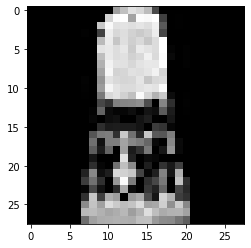

La clase obtenida es: Sneaker


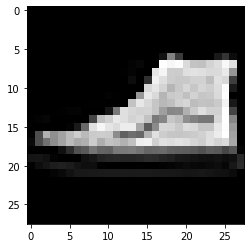

La clase obtenida es: Sneaker


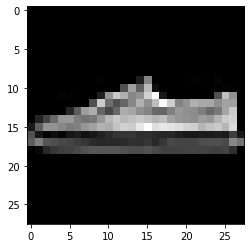

La clase obtenida es: Shirt


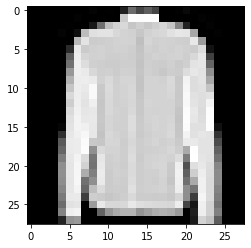

La clase obtenida es: Shirt


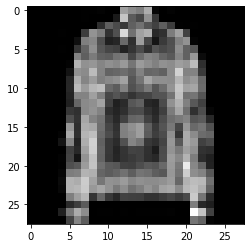

In [6]:
imgs_to_show = 5

for _ in range(imgs_to_show):

    # Cargamos un batch de imagenes
    images, images_classes = next(iter(train_loader))

    # Nos quedamos con la primera imagen del batch
    img, img_class = images[0], images_classes[0]

    # Mostramos alguna informacion de la imagen
    print(f"La clase obtenida es: {classes[img_class]}")

    # Re-escalamos y mostramos la imagen
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))

Mostramos ahora unas cuantas imágenes de forma simultánea:

Mostramos ahora los tamaños del dataset:

In [7]:
print(f"Tenemos {len(train_dataset)} imágenes de entrenamiento")
print(f"Tenemos {len(test_dataset)} imágenes de test")

Tenemos 60000 imágenes de entrenamiento
Tenemos 10000 imágenes de test


# Definiendo el modelo base

- A continuación, definimos el modelo que vamos a usasr como base para nuestra red siamesa
- Usaremos el modelo pre-entrenado ResNet18, pre-entrenado en ImageNet

In [8]:
class ResNet18(torch.nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # Tomamos el modelo pre-entrenado ResNet18
        self.pretrained = models.resnet18(pretrained=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Usamos directamente la red pre-entrenada para hacer el forward
        return self.pretrained.forward(x)


# Generación de triples

- Para entrenar la red siamesa, necesitamos dar triples con los que computar el *triplet loss*
- Por ello, es necesaria una fase previa de *triplets mining*
- En todos los casos, crearemos *Datasets* de *Pytorch* para representar la creación de los triples
- Hacemos esto basándonos el la [documentación oficial de Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

## Generación de triples aleatorios

- Es la forma más sencilla y directa para generar triples
- Usaremos esta generación como baseline para más tarde realizar comparaciones

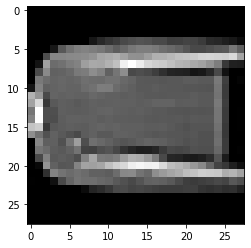

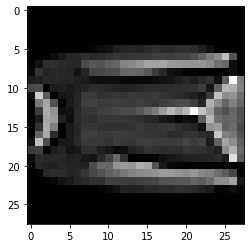

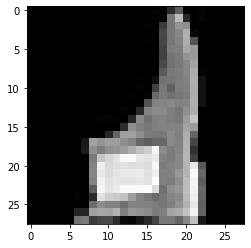

In [32]:
# TODO -- hay que implementar esto
from torch.utils.data import RandomSampler


class RandomTriplets(Dataset):
    """
    Dataset en el que los elementos son triples obtenidos de forma aleatoria
    """

    def __init__(self, base_data: Dataset, custom_len: int, transform = None):
        self.base_data = base_data
        self.custom_len = custom_len
        self.transform = transform
        self.random_sampler = RandomSampler(self.base_data, replacement=True, num_samples=1, generator=None)
        
        # Por motivos de eficiencia, pre-computamos una lista de listas, de forma
        # que tengamos disponibles las listas con las posiciones de cada clase por
        # separado.
        self.posiciones_clases = self.__precompute_list_of_classes()

    def __len__(self):
        """
        Devolvemos el tamaño del dataset
        Como estamos generando triples aleatorios, devolvemos el tamaño definido
        por parametro
        """
        return self.custom_len

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Funcion que es llamada cuando se hace dataset[idx]
        En vez de devolver una imagen (que es lo comun en esta clase dataset), 
        devolvemos un triple (anchor, positive, negative) aleatorio
        """

        # Hacemos esto por temas de eficiencia
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Tomamos una imagen aleatoria que sera el ancla
        anchor, anchor_class = self.base_data[next(iter(self.random_sampler))]

        # Tomamos una imagen de la misma clase, que sera la positiva, de forma aleatoria
        random_index = np.random.choice(self.posiciones_clases[anchor_class])
        positive, positive_class = self.base_data[random_index]

        # Tomamos una imagen de otra clase, que sera la negativa
        # Empiezo tomando una clase que no sea la del anchor
        posible_classes = list(range(10))
        posible_classes.remove(anchor_class)
        negative_class = np.random.choice(posible_classes)

        # Ahora tomamos un indice aleatorio de esta clase negativa
        random_index = np.random.choice(self.posiciones_clases[negative_class])
        negative, negative_class = self.base_data[random_index]
        
        # Generamos ahora el triple
        triplet = [anchor, positive, negative]

        # Aplicamos la transformacion dada al dataset al ejemplo que devolvemos
        if self.transform:
            triplet = [self.transform(np.array(img)) for img in triplet]

        return triplet

    def __precompute_list_of_classes(self) -> List[List[int]]:
        """
        Calcula la lista con las listas de posiciones de cada clase por separado
        """
        # Inicializamos la lista de listas
        posiciones_clases = [[] for _ in range(10)]

        # Recorremos el dataset y colocamos los indices donde corresponde
        for idx, element in enumerate(self.base_data):
            _, img_class = element
            posiciones_clases[img_class].append(idx)

        return posiciones_clases

random_triplets = RandomTriplets(
    base_data = train_dataset,
    custom_len = 100,
    transform = transform
)

# TODO -- esto habria que borrarlo, esta aqui para hacer pruebas
#Visualizamos un triple
custom_triplet = random_triplets[2]
for i in custom_triplet :
    i = i.reshape((28, 28))
    show_img(i, color_format_range = (-1.0, 1.0))

In [34]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

# Entrenamiento del modelo

In [35]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=100000000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for (anchor_img, positive_img, negative_img) in dataloaders: #hay que poder poner dataloaders[phase]:
                #Cada inputs es una tripleta
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        anchor_out = model(anchor_img[None,...])
                        positive_out = model(positive_img[None,...])
                        negative_out = model(negative_img[None,...])
                        loss = criterion(anchor_out,positive_out,negative_out)

                    #_, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size=32
net = ResNet18().cuda()

optimizer=optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
criterion=TripletLoss()

print(net)

ResNet18(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [47]:
train_model(net,random_triplets,criterion,optimizer)

Epoch 0/24
----------


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 28, 1, 28] to have 3 channels, but got 28 channels instead

In [ ]:
net.train()
#He tenido que añadir esto porque como uso batches de tam 1 da problemas al llamar a net(img)
net.eval()

# TODO -- Hay que solucionar el problema de que se pasa de iteraciones y no cambia de época
# TODO -- Hay que solucionar el problema de que la función de pérdida no calcula correctamente su valor
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(random_triplets, desc="Training")):
        
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        anchor_img=anchor_img.reshape(1,28,28)
        anchor_img= anchor_img.repeat(3, 1, 1)
        positive_img=positive_img.reshape(1,28,28)
        positive_img= positive_img.repeat(3, 1, 1)
        negative_img=negative_img.reshape(1,28,28)
        negative_img= negative_img.repeat(3, 1, 1)
        
        optimizer.zero_grad()
        anchor_out = net(anchor_img[None,...])
        positive_out = net(positive_img[None,...])
        negative_out = net(negative_img[None,...])
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
        print(anchor_out)
        
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

In [27]:
# Set the training parameters
parameters = dict()
parameters["lr"] = 0.001
parameters["momentum"] = 0.9
parameters["criterion"] = triplet_loss_batch_hard
parameters["epochs"] = 10

# We save the model in different paths wether we're running
# local or in cloud
# TODO -- esto ponerlo en constantes y con buenos nombres
save_model_path = None
if RUNNING_ENV == "local": save_model_path = "./saved_models"
if RUNNING_ENV == "remote": save_model_path = "drive/MyDrive/ml/Modelos/MNIST-ReID/saved_models"

# Network we are going to train
net = ResNet18()
batch_size=32

# Specifying the trainning logger
logger = TripletLogger(
    iterations = 200 * batch_size, # TODO -- document why multiplying batch_size 
    loss_func = triplet_loss_batch_hard, 
    net = net,
    training_perc = 0.2, 
    validation_perc = 1.0
)

# If running in cloud, show tensorboard inline
if RUNNING_ENV == "remote":
    %load_ext tensorboard
    %tensorboard --logdir runs

# Train process
core.batch_hard_train(
    net, 
    save_model_path, 
    parameters, 
    train_loader = train_loader, 
    validation_loader = test_loader, # TODO -- we are using test dataset as validation dataset 
    name = "LuNet", 
    logger = logger,
    snapshot_iterations = 10_000 
)

# Close the logger when we are done with the training
logger.close()

AttributeError: 'ResNet18' object has no attribute 'parameters'

# Evaluación del modelo

- Mostramos algunas métricas fundamentales sobre el conjunto de

In [ ]:
# TODO -- hay que implementar algunas metricas

# Adaptación del modelo para usarlo como clasificador

- Nuestro modelo genera un *embedding*
- Adaptamos el modelo para que, a partir de dicho embedding, podamos usarlo como un clasificador

In [ ]:
# TODO -- adaptar el modelo

## Evaluación del clasificador obtenido

- Ahora que hemos adaptado el modelo para usarlo como clasificador, podemos consultar ciertas métricas de clasificación

In [ ]:
# TODO -- implementar las métricas de clasificación